#### Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/persian-numbers/Train 60000.cdb
/kaggle/input/persian-numbers/RemainingSamples.cdb
/kaggle/input/persian-numbers/Test 20000.cdb
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.exe
/kaggle/input/persian-numbers/ReadCDB_VC/resource.h
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.rc
/kaggle/input/persian-numbers/ReadCDB_VC/stdafx.cpp
/kaggle/input/persian-numbers/ReadCDB_VC/ReadMe.txt
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.cpp
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VCDlg.cpp
/kaggle/input/persian-numbers/ReadCDB_VC/stdafx.h
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.sln
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VCDlg.h
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.vcproj
/kaggle/input/persian-numbers/ReadCDB_VC/ReadCDB_VC.h
/kaggle/input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.rc2
/kaggle/input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.ico
/kaggle/input/persian-numbers/ReadCDB_VC/res/ReadCDB_VC.manifest
/kaggle/input/p

In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import external libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import time
%matplotlib inline

Check for CUDA

In [3]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)

True
True
cuda


#### Read inputs

#### Separate into labels and training images and reshape the images

In [4]:

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [5]:
X_train, y_train = read_hoda_dataset(dataset_path='/kaggle/input/persian-numbers/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)

In [6]:
train_images, test_images, train_labels, test_labels = train_test_split(
    X_train.astype(np.float32), y_train, test_size=0.2, random_state=1374)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=1374)

In [7]:
train_images = train_images.reshape(train_images.shape[0], 32, 32)
val_images = val_images.reshape(val_images.shape[0], 32, 32)
test_images = test_images.reshape(test_images.shape[0], 32, 32)

#### Plot some images to see samples

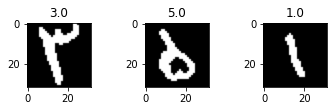

In [8]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

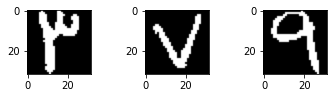

In [9]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(val_images[i].squeeze(), cmap=plt.get_cmap('gray'))

#### Convert images to tensors
Normalize the images too

In [10]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor.type(torch.LongTensor))

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor.type(torch.LongTensor))

#test
test_images_tensor = torch.tensor(test_images)/255.0

#### Load images into the data generator

In [11]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

#### Plot some sample images using the data generator

#### Define the CNN Model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*8*8, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [13]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### Define the optimizer and loss functions

In [14]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
#optimizer = optim.RMSprop(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

#### Training the Model

In [15]:
acc={'Val_acc':[] , 'Loss':[]}
def train_model(num_epoch):
    conv_model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    exp_lr_scheduler.step()
def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = conv_model(data)
        
        loss += F.cross_entropy(output, target, reduction='sum').data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    acc['Val_acc'].append(100. * correct / len(data_loader.dataset))
    acc['Loss'].append(loss)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    

**after 8 epoch we get to 99 percent accuracy so we decrease the num_epoch from 25 to 10**

In [16]:
#num_epochs = 25
start_time = time.time()
while(True):
    try:
        num_epochs = 10
        for n in range(num_epochs):
            train_model(n)
            evaluate(val_loader)
        break
    except:
        pass
print("--- %s seconds ---" % (time.time() - start_time))

Train Epoch: 0 [1600/38400 (4%)]	Loss: 0.538880
Train Epoch: 0 [3200/38400 (8%)]	Loss: 0.285790
Train Epoch: 0 [4800/38400 (12%)]	Loss: 0.443951
Train Epoch: 0 [6400/38400 (17%)]	Loss: 0.174274
Train Epoch: 0 [8000/38400 (21%)]	Loss: 0.636379
Train Epoch: 0 [9600/38400 (25%)]	Loss: 0.133667
Train Epoch: 0 [11200/38400 (29%)]	Loss: 0.051756
Train Epoch: 0 [12800/38400 (33%)]	Loss: 0.417113
Train Epoch: 0 [14400/38400 (38%)]	Loss: 0.053242
Train Epoch: 0 [16000/38400 (42%)]	Loss: 0.337165
Train Epoch: 0 [17600/38400 (46%)]	Loss: 0.191935
Train Epoch: 0 [19200/38400 (50%)]	Loss: 0.221756
Train Epoch: 0 [20800/38400 (54%)]	Loss: 0.173856
Train Epoch: 0 [22400/38400 (58%)]	Loss: 0.303092
Train Epoch: 0 [24000/38400 (62%)]	Loss: 0.247558
Train Epoch: 0 [25600/38400 (67%)]	Loss: 0.074553
Train Epoch: 0 [27200/38400 (71%)]	Loss: 0.060501
Train Epoch: 0 [28800/38400 (75%)]	Loss: 0.186660
Train Epoch: 0 [30400/38400 (79%)]	Loss: 0.046407
Train Epoch: 0 [32000/38400 (83%)]	Loss: 0.100640
Train Ep

#### Make predictions on the test set

In [17]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = conv_model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [18]:
test_set_preds = make_predictions(test_loader)

 0    9    2    3    6    1    9    8    4   

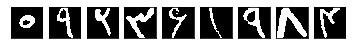

In [19]:
#test samples
for i in range(9):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[i].item()}' , end="   ")
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()




In [20]:
from sklearn.metrics import accuracy_score


accuracy_score(test_labels , test_set_preds)

0.9945833333333334

In [21]:
wrongs=[]
for i,v in enumerate(test_set_preds):
    if v.item() != test_labels[i]:
        wrongs.append(i)

 3    3    4    5    5    3    9    7    6   

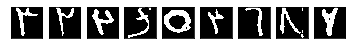

In [22]:
#Mistakes
for i,value in enumerate(wrongs[:9]):
    plt.subplot(1,9,i+1, xticks=[], yticks=[])
    print(f' {test_set_preds[value].item()}' , end="   ")
    plt.imshow(test_images[value].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()
